In [4]:
!pip install kaggle

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [55]:
%cd /content/drive/MyDrive
!git clone https://github.com/fyp6508/Accident_Detection.git



/content/drive/MyDrive
Cloning into 'Accident_Detection'...


In [56]:
%cd /content/drive/MyDrive/Accident_Detection




/content/drive/MyDrive/Accident_Detection


In [1]:
import tensorflow as tf

# Check if a GPU is available
gpu_available = tf.config.list_physical_devices('GPU')

if gpu_available:
    print("GPU is available.")
else:
    print("GPU is not available.")


GPU is available.


In [6]:
from google.colab import files

# Upload the Kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [12]:
!kaggle datasets download -d ckay16/accident-detection-from-cctv-footage

... resuming from 24117248 bytes (237394675 bytes left) ...
100% 249M/249M [00:13<00:00, 22.5MB/s]
100% 249M/249M [00:13<00:00, 17.8MB/s]


In [13]:
# Specify the path to the zip file
zip_file_path = '/content/accident-detection-from-cctv-footage.zip'

# Specify the target directory for extraction
extracted_dir = '/content/accident-detection-from-cctv-footage'

# Unzip the file
!unzip -q "$zip_file_path" -d "$extracted_dir"


In [36]:
!kaggle datasets download -d fahaddalwai/cctvfootagevideo

100% 9.68M/9.68M [00:01<00:00, 11.7MB/s]
100% 9.68M/9.68M [00:01<00:00, 6.66MB/s]


In [37]:
# Specify the path to the zip file
zip_file_path = '/content/cctvfootagevideo.zip'

# Specify the target directory for extraction
extracted_dir = '/content/cctvfootagevideo'

# Unzip the file
!unzip -q "$zip_file_path" -d "$extracted_dir"

In [14]:
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

In [15]:
batch_size = 100
img_height = 250
img_width = 250

In [16]:
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/accident-detection-from-cctv-footage/data/train',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/accident-detection-from-cctv-footage/data/test',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size)

validation_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    '/content/accident-detection-from-cctv-footage/data/val',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size)

Found 791 files belonging to 2 classes.
Found 100 files belonging to 2 classes.
Found 98 files belonging to 2 classes.


In [17]:
class_names = training_ds.class_names

## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
img_shape = (img_height, img_width, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [19]:
model = tf.keras.Sequential([
    base_model,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(128, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(len(class_names), activation= 'softmax')
])

In [20]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
history = model.fit(training_ds, validation_data = validation_ds, epochs = 50)

Epoch 1/50
8/8 [==============================] - 20s 1s/step - loss: 0.9112 - accuracy: 0.5575 - val_loss: 0.6164 - val_accuracy: 0.6633
Epoch 2/50
8/8 [==============================] - 2s 232ms/step - loss: 0.5446 - accuracy: 0.7307 - val_loss: 0.5711 - val_accuracy: 0.7041
Epoch 3/50
8/8 [==============================] - 2s 233ms/step - loss: 0.3925 - accuracy: 0.8344 - val_loss: 0.4438 - val_accuracy: 0.7857
Epoch 4/50
8/8 [==============================] - 2s 283ms/step - loss: 0.2663 - accuracy: 0.8925 - val_loss: 0.3709 - val_accuracy: 0.8163
Epoch 5/50
8/8 [==============================] - 2s 328ms/step - loss: 0.1601 - accuracy: 0.9507 - val_loss: 0.2793 - val_accuracy: 0.9082
Epoch 6/50
8/8 [==============================] - 2s 234ms/step - loss: 0.1014 - accuracy: 0.9633 - val_loss: 0.2200 - val_accuracy: 0.9184
Epoch 7/50
8/8 [==============================] - 2s 230ms/step - loss: 0.0707 - accuracy: 0.9747 - val_loss: 0.1890 - val_accuracy: 0.9184
Epoch 8/50
8/8 [======

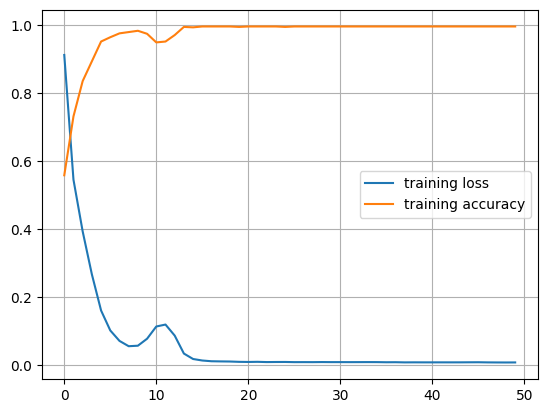

In [22]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

In [24]:
AccuracyVector = []
plt.figure(figsize=(40, 40))
for images, labels in testing_ds.take(1):
    predictions = model.predict(images)
    predlabel = []
    prdlbl = []

    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))

    AccuracyVector = np.array(prdlbl) == labels
    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)

Output hidden; open in https://colab.research.google.com to view.

In [25]:
truePositive=0
trueNegative=0
falsePositive=0
falseNegative=0
#positive event is accident negative event is non accident
for i in range(0,100):
    if(predlabel[i]==class_names[labels[i]] and predlabel[i]=='Accident'):
        truePositive+=1
    elif(predlabel[i]==class_names[labels[i]] and predlabel[i]=='Non Accident'):
        trueNegative+=1
    elif(predlabel[i]=='Non Accident' and class_names[labels[i]]=='Accident'):
        falseNegative+=1
    else:
        falsePositive+=1

In [26]:
print(f'True positives are: {truePositive}')
print(f'True negatives are: {trueNegative}')
print(f'False negatives are: {falseNegative}')
print(f'False positives are: {falsePositive}')

True positives are: 43
True negatives are: 49
False negatives are: 4
False positives are: 4


In [28]:
!pip install keras

In [30]:
def predict_frame(img):
    img_array = tf.keras.utils.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    prediction=(model.predict(img_batch) > 0.5).astype("int32")
    if(prediction[0][0]==0):
        return("Accident Detected")
    else:
        return("No Accident")

In [38]:
import cv2
image=[]
label=[]

c=1
cap= cv2.VideoCapture('/content/cctvfootagevideo/videoplayback (online-video-cutter.com).mp4')
while True:
    grabbed, frame = cap.read()
    if c%30==0:
        print(c)
        resized_frame=tf.keras.preprocessing.image.smart_resize(frame, (img_height, img_width), interpolation='bilinear')
        image.append(frame)
        label.append(predict_frame(resized_frame))
        if(len(image)==75):
            break
    c+=1

cap.release()

30
1/1 [==============================] - 1s 816ms/step
60
1/1 [==============================] - 0s 23ms/step
90
1/1 [==============================] - 0s 21ms/step
120
1/1 [==============================] - 0s 22ms/step
150
1/1 [==============================] - 0s 21ms/step
180
1/1 [==============================] - 0s 22ms/step
210
1/1 [==============================] - 0s 24ms/step
240
1/1 [==============================] - 0s 25ms/step
270
1/1 [==============================] - 0s 24ms/step
300
1/1 [==============================] - 0s 25ms/step
330
1/1 [==============================] - 0s 30ms/step
360
1/1 [==============================] - 0s 22ms/step
390
1/1 [==============================] - 0s 24ms/step
420
1/1 [==============================] - 0s 23ms/step
450
1/1 [==============================] - 0s 23ms/step
480
1/1 [==============================] - 0s 24ms/step
510
1/1 [==============================] - 0s 23ms/step
540
1/1 [==============================] - 0s 23ms

Accident Detected
AxesImage(size=(360, 640))


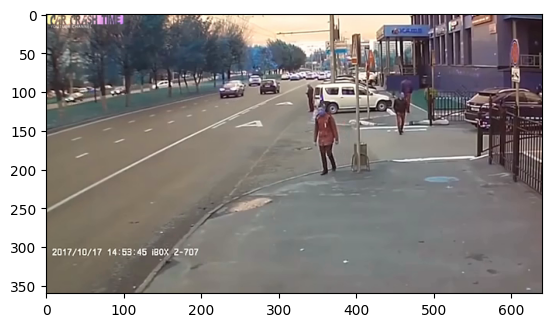

In [39]:
print(label[20])
print(plt.imshow(image[20]))

In [40]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('tf_lite_model.tflite', 'wb') as f:
    f.write(tflite_model)

In [41]:
interpreter = tf.lite.Interpreter(model_path = 'tf_lite_model.tflite')
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 250 250   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 2]
Output Type: <class 'numpy.float32'>


In [42]:
interpreter.resize_tensor_input(input_details[0]['index'], (1, 250, 250,3))
interpreter.resize_tensor_input(output_details[0]['index'], (1, 2))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 250 250   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 2]
Output Type: <class 'numpy.float32'>


In [47]:
from PIL import Image
from glob import glob

# Find all the files in the directory
files = glob("/content/accident-detection-from-cctv-footage/data/train/Non Accident/*.jpg")

# Open one of the files
im = Image.open(files[0]).resize((250, 250))

# Convert the image to an array
img_array = tf.keras.utils.img_to_array(im)

# Expand the dimensions of the array
img_batch = np.expand_dims(img_array, axis=0)

Prediction results: 0.99998534
AxesImage(size=(250, 250))


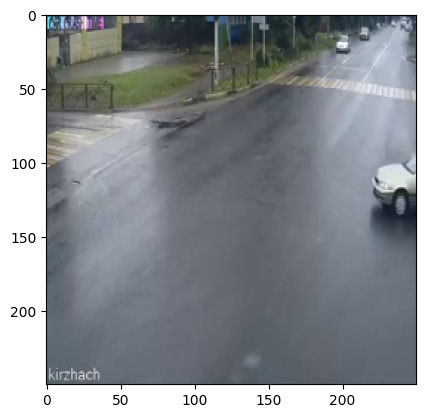

In [48]:
interpreter.set_tensor(input_details[0]['index'], img_batch)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results:", tflite_model_predictions[0][1])
print(plt.imshow(im))